<a href="https://colab.research.google.com/github/AlexandreLarget/tensorflow_certification_training/blob/main/06_transfer_learning_in__TF_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TF part 3 : Scaling up Food Vision mini

From Original Food101 paper, our baseline to beat is 50.76%

In [ ]:
!nvidia-smi

Wed Oct 12 02:27:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    41W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-10-12 02:27:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-12 02:27:08 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-10-12 02:27:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 172.253.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   292MB/s    in 5.4s    

2022-10-12 02:27:16 (286 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images_classes ?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/eggs_benedict'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_carbonara'.
There are 0 directorie

In [ ]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer
* Build a headless (no top layers) Functional EfficientNetb0 backbones_model
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset amd validate on 15% of the test Data)

In [ ]:
# Create checkpoint callbacks
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)

In [ ]:
# Create data augmentation layer
from tensorflow.keras import layers, preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # Required for ResNet50
], name="data_augmentation")

In [ ]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only for training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [ ]:
# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate the results on only 15% of the data
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 40s 102ms/step - loss: 3.4605 - accuracy: 0.2463 - val_loss: 2.7255 - val_accuracy: 0.3882
Epoch 2/5
237/237 [==============================] - 18s 76ms/step - loss: 2.3428 - accuracy: 0.4650 - val_loss: 2.2390 - val_accuracy: 0.4632
Epoch 3/5
237/237 [==============================] - 16s 68ms/step - loss: 1.9784 - accuracy: 0.5291 - val_loss: 2.0762 - val_accuracy: 0.4791
Epoch 4/5
237/237 [==============================] - 15s 62ms/step - loss: 1.7726 - accuracy: 0.5636 - val_loss: 1.9976 - val_accuracy: 0.4838
Epoch 5/5
237/237 [==============================] - 15s 61ms/step - loss: 1.5925 - accuracy: 0.6067 - val_loss: 1.9838 - val_accuracy: 0.4831


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 20s 25ms/step - loss: 1.7178 - accuracy: 0.5511


[1.7178341150283813, 0.5510891079902649]

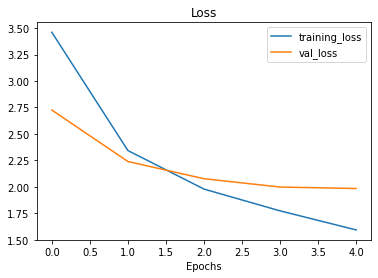

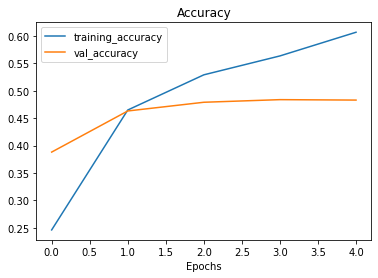

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

The plot loss curves should follow each other.
But the validation curve reach a kond of a plateau.
This can reveal overfitting.

## Fine tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 910,821
Non-trainab

In [ ]:
# Recompile model with lower learning rate when fine tuning
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # 10x lower than the default learning rate
              metrics=["accuracy"])

In [ ]:
# What layers in the model is trainable ?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 
# model has already run on 5 epochs, we're taking back the best epoch of the first run

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent, 
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 23s 67ms/step - loss: 1.3469 - accuracy: 0.6540 - val_loss: 1.9529 - val_accuracy: 0.4958
Epoch 6/10
237/237 [==============================] - 14s 57ms/step - loss: 1.2396 - accuracy: 0.6714 - val_loss: 1.9427 - val_accuracy: 0.4989
Epoch 7/10
237/237 [==============================] - 13s 56ms/step - loss: 1.1465 - accuracy: 0.6952 - val_loss: 1.9315 - val_accuracy: 0.5082
Epoch 8/10
237/237 [==============================] - 13s 54ms/step - loss: 1.0799 - accuracy: 0.7105 - val_loss: 1.9376 - val_accuracy: 0.4984
Epoch 9/10
237/237 [==============================] - 12s 52ms/step - loss: 1.0174 - accuracy: 0.7291 - val_loss: 1.9253 - val_accuracy: 0.5034
Epoch 10/10
237/237 [==============================] - 12s 51ms/step - loss: 0.9704 - accuracy: 0.7452 - val_loss: 1.9096 - val_accuracy: 0.5048


In [ ]:
# Evaluate on the all test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 19s 25ms/step - loss: 1.6156 - accuracy: 0.5735


[1.6156197786331177, 0.5735049247741699]

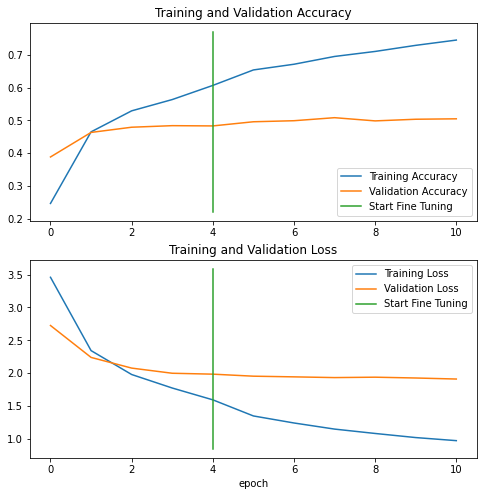

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [ ]:
## Saving and loading our model

# Save
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")


In [ ]:
# Load and evaluate

loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 22s 27ms/step - loss: 1.6156 - accuracy: 0.5735


[1.6156197786331177, 0.5735049247741699]

In [ ]:
all_classes_10_percent_fine_tune_results

[1.6156197786331177, 0.5735049247741699]

## Evaluate the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then find out which predictions were the "most" wrong

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-10-12 02:32:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 74.125.201.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   123MB/s    in 0.4s    

2022-10-12 02:32:45 (123 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 23s 27ms/step - loss: 1.8026 - accuracy: 0.6078


[1.8026230335235596, 0.6078416109085083]

## Making predictions with our trained model

In [ ]:
# Make predictions with our model
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 21s 25ms/step


In [ ]:
len(test_data)

790

In [ ]:
len(preds_probs)

25250

In [ ]:
# What is the shape of our prediction?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see wht the 10 first predictions looks like
preds_probs[:10]

array([[5.91322035e-02, 3.55033831e-06, 4.09886353e-02, ...,
        1.40797274e-09, 8.30282224e-05, 3.07384273e-03],
       [9.63881552e-01, 1.37996881e-09, 8.44866503e-04, ...,
        5.41545123e-05, 7.82427855e-12, 9.84385018e-10],
       [9.59356785e-01, 3.25796391e-05, 1.48706581e-03, ...,
        7.18787362e-07, 5.48217713e-07, 4.03897866e-05],
       ...,
       [4.73044395e-01, 1.28940485e-07, 1.47754629e-03, ...,
        5.97769977e-04, 6.66905471e-05, 2.34898871e-05],
       [4.44917381e-02, 4.73169337e-07, 1.21356264e-01, ...,
        6.33103218e-06, 7.52281221e-06, 3.67858610e-03],
       [7.24548817e-01, 1.92807170e-09, 5.21486800e-05, ...,
        1.22459047e-03, 1.57856728e-09, 9.65479703e-05]], dtype=float32)

In [ ]:
preds_probs[0], sum(preds_probs[0])

(array([5.91322035e-02, 3.55033831e-06, 4.09886353e-02, 1.05888642e-09,
        8.10529066e-09, 8.55071036e-09, 8.06020580e-07, 8.48579532e-07,
        1.97931731e-05, 8.02823081e-07, 3.15482973e-09, 9.78234084e-07,
        2.84018402e-04, 7.78414055e-10, 7.34853791e-04, 3.88626249e-05,
        6.45552109e-06, 2.48155834e-06, 3.78458317e-05, 2.06835480e-07,
        1.55680827e-05, 8.09652249e-07, 2.61886407e-06, 2.00351778e-07,
        8.34536422e-07, 5.39539451e-06, 3.72946897e-06, 1.31040698e-08,
        2.74974946e-03, 2.78517418e-05, 6.79351575e-10, 2.53809776e-05,
        1.67110134e-04, 7.62230612e-10, 4.02211881e-04, 1.30008537e-08,
        1.79155654e-06, 1.43932834e-06, 2.30142381e-02, 8.20098194e-07,
        8.56382599e-07, 1.70450119e-06, 7.00793589e-06, 1.84022841e-08,
        2.84311739e-07, 7.97025677e-06, 2.05774313e-06, 1.84723106e-07,
        3.35114692e-08, 3.15639511e-04, 1.04272849e-05, 8.53787697e-07,
        8.48315120e-01, 1.04959663e-05, 4.37914935e-07, 3.711842

In [ ]:
print("The highest probability for our sample 0 is located in position:", preds_probs[0].argmax())
print("The probability value is :", preds_probs[0].max())

The highest probability for our sample 0 is located in position: 52
The probability value is : 0.8483151


In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the prediction classes of each labels
pred_classes = preds_probs.argmax(axis=1)

pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many classes do we have ?
len(pred_classes)

25250

In [ ]:
# To get out test labels, we need to unravel our test_data BatchDataset
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
len(y_labels)

25250

## Evaluating our model's predictions

In [ ]:
results_downloaded_model

[1.8026230335235596, 0.6078416109085083]

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.6078415841584158

## Let's get visual making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labes vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

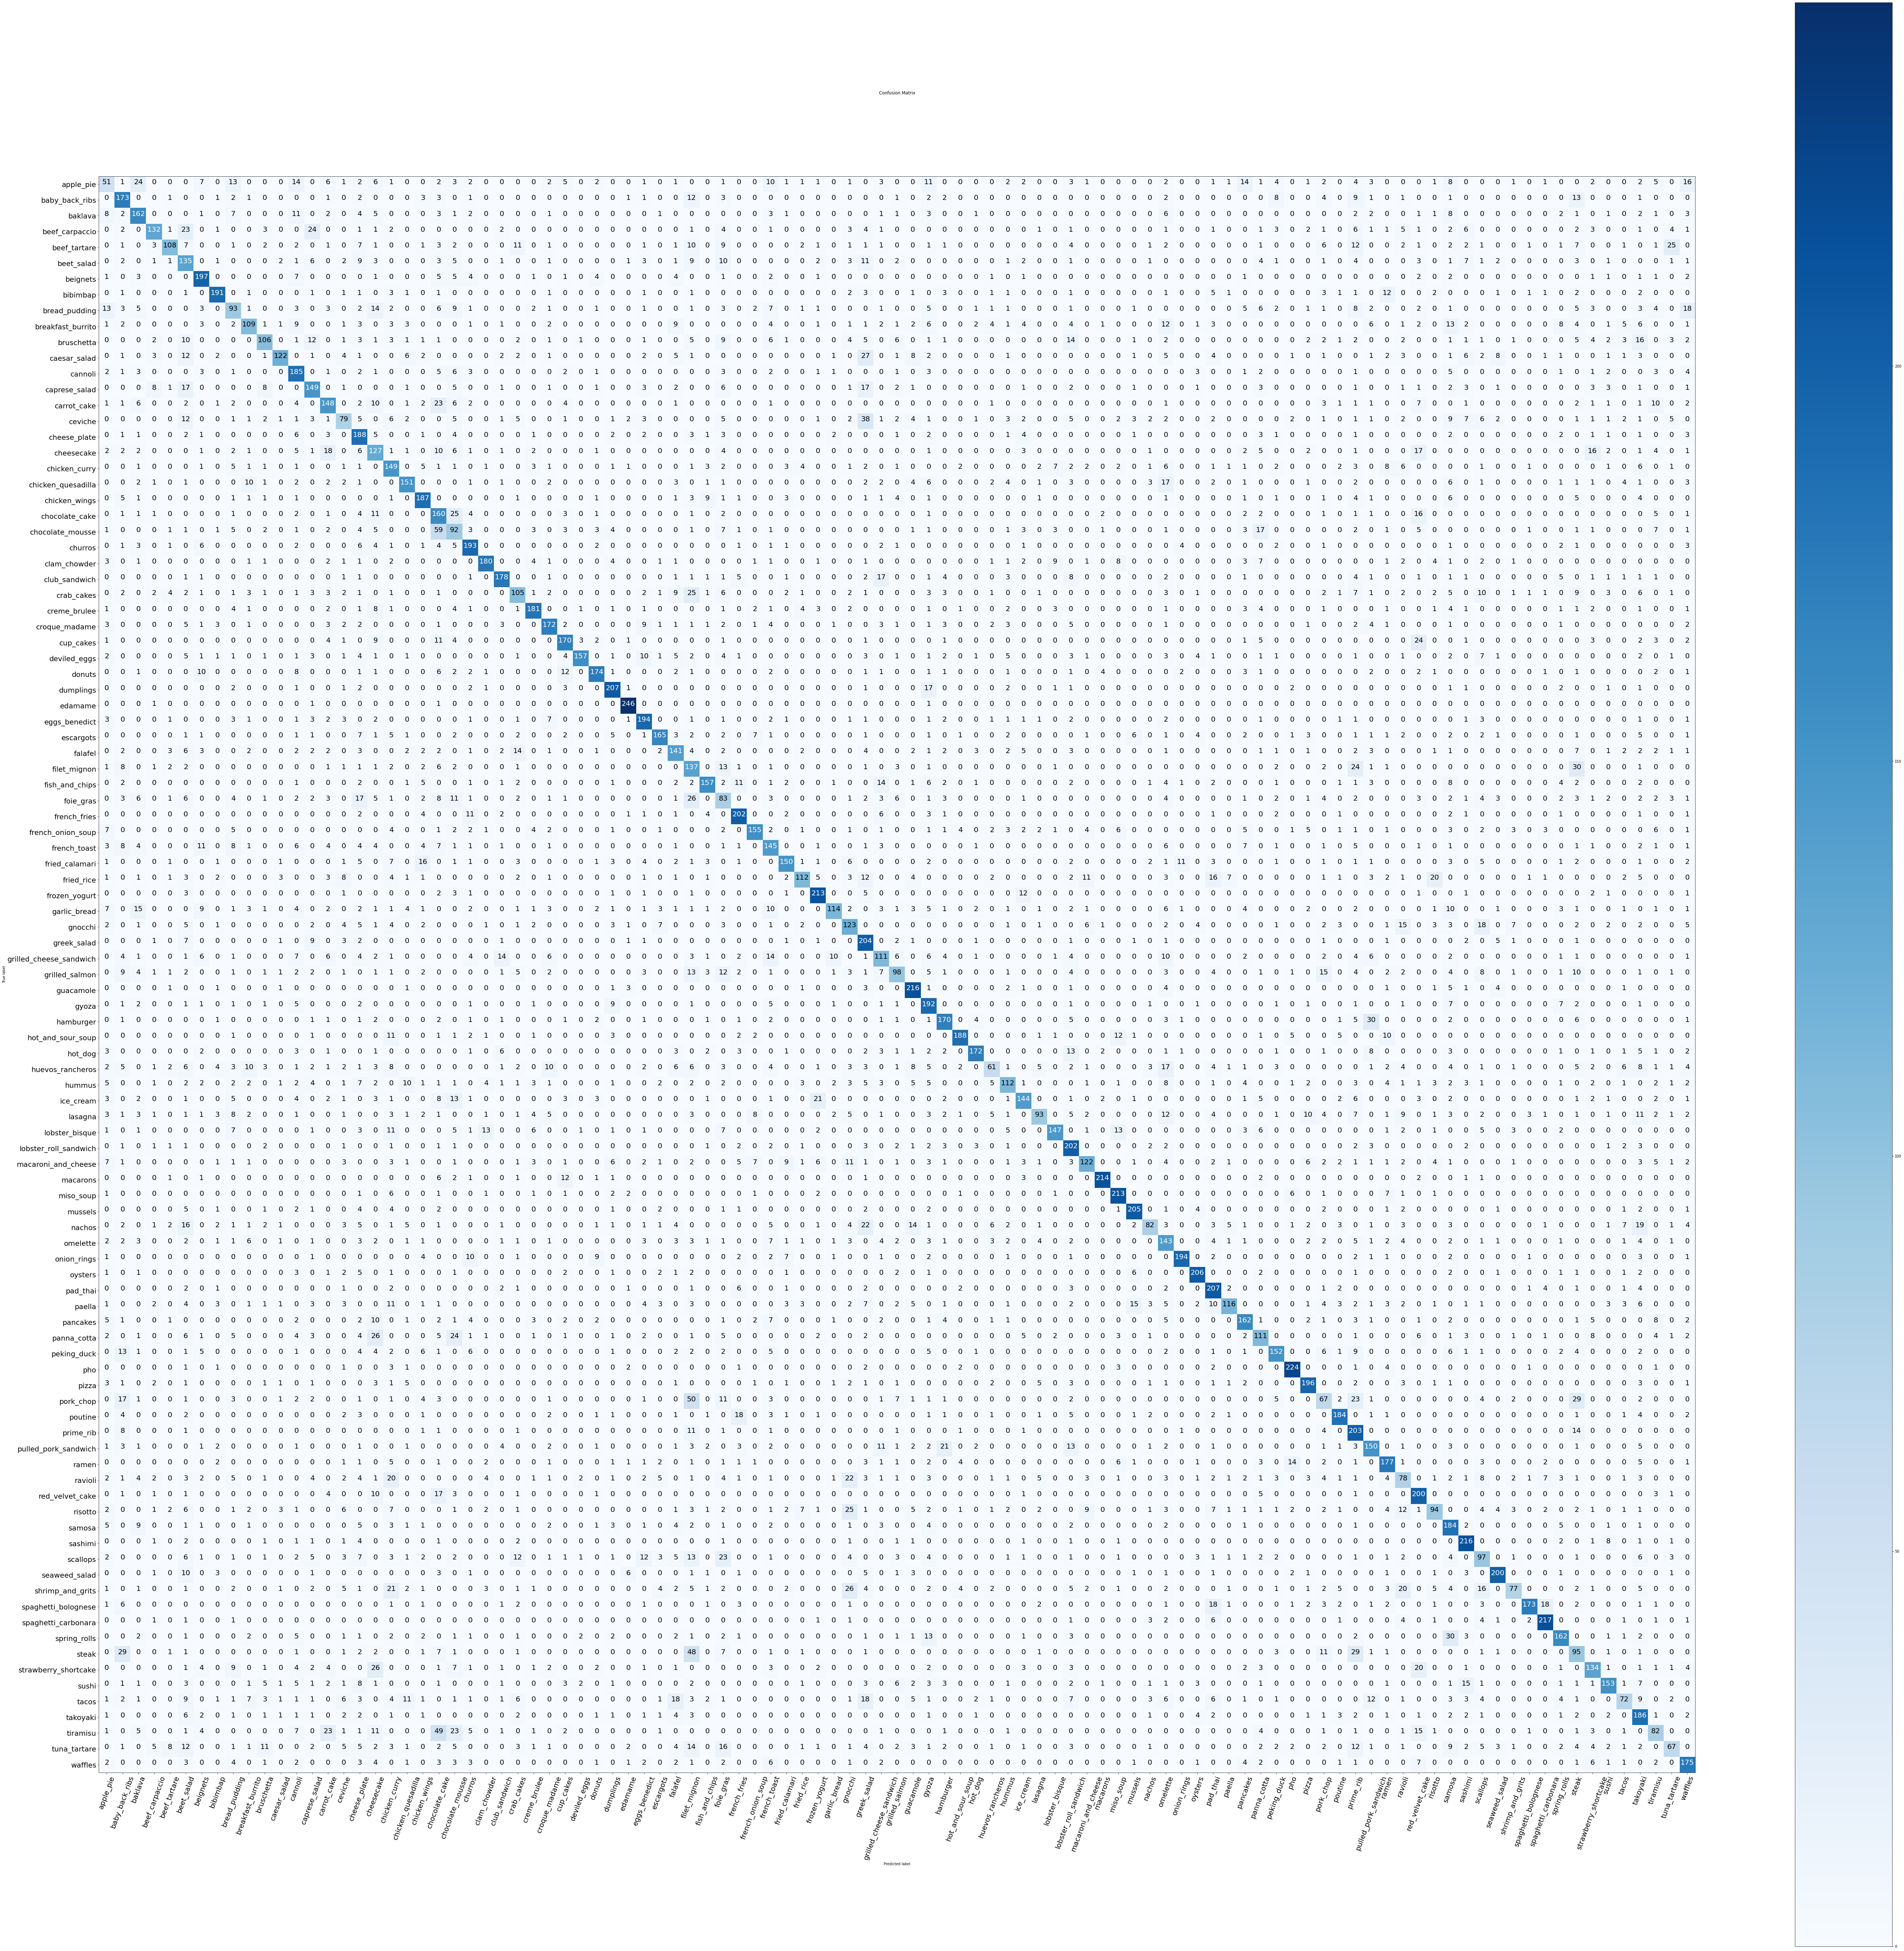

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation going with sklearn classification report.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5644599303135889,
  'recall': 0.648,
  'f1-score': 0.6033519553072626,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.3426395939086294,
  'recall': 0.54,
  'f1-score': 0.4192546583850932,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support':

Let's plot all our classes F1 score...

In [ ]:
class_names = test_data.class_names
class_names[98]

'tiramisu'

In [ ]:
classification_report_dict["99"]["f1-score"]

0.35356200527704484

In [ ]:
# Create empty dictionary
class_f1_score = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break # stop once we got to meta data
  else:
    class_f1_score[class_names[int(k)]] = v["f1-score"]

In [ ]:
class_f1_score

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6033519553072626,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.4192546583850932,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42689075630252105,
 'chicken_curry': 0.5,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee': 0.74948240165

In [ ]:
import pandas as pd
f1_score_df = pd.DataFrame({"class_names": list(class_f1_score.keys()),
                            "f1-score": list(class_f1_score.values())})

In [ ]:
f1_score = f1_score_df.sort_values("f1-score", ascending=False)

In [ ]:
f1_score[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.868217
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.814664
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

In [ ]:
f1_score[-10:]

class_names  f1-score
96             tacos  0.380952
15           ceviche  0.367442
99      tuna_tartare  0.353562
82           ravioli  0.344371
93             steak  0.342342
56  huevos_rancheros  0.339833
22  chocolate_mousse  0.329159
77         pork_chop  0.308756
39         foie_gras  0.297491
0          apple_pie  0.240566

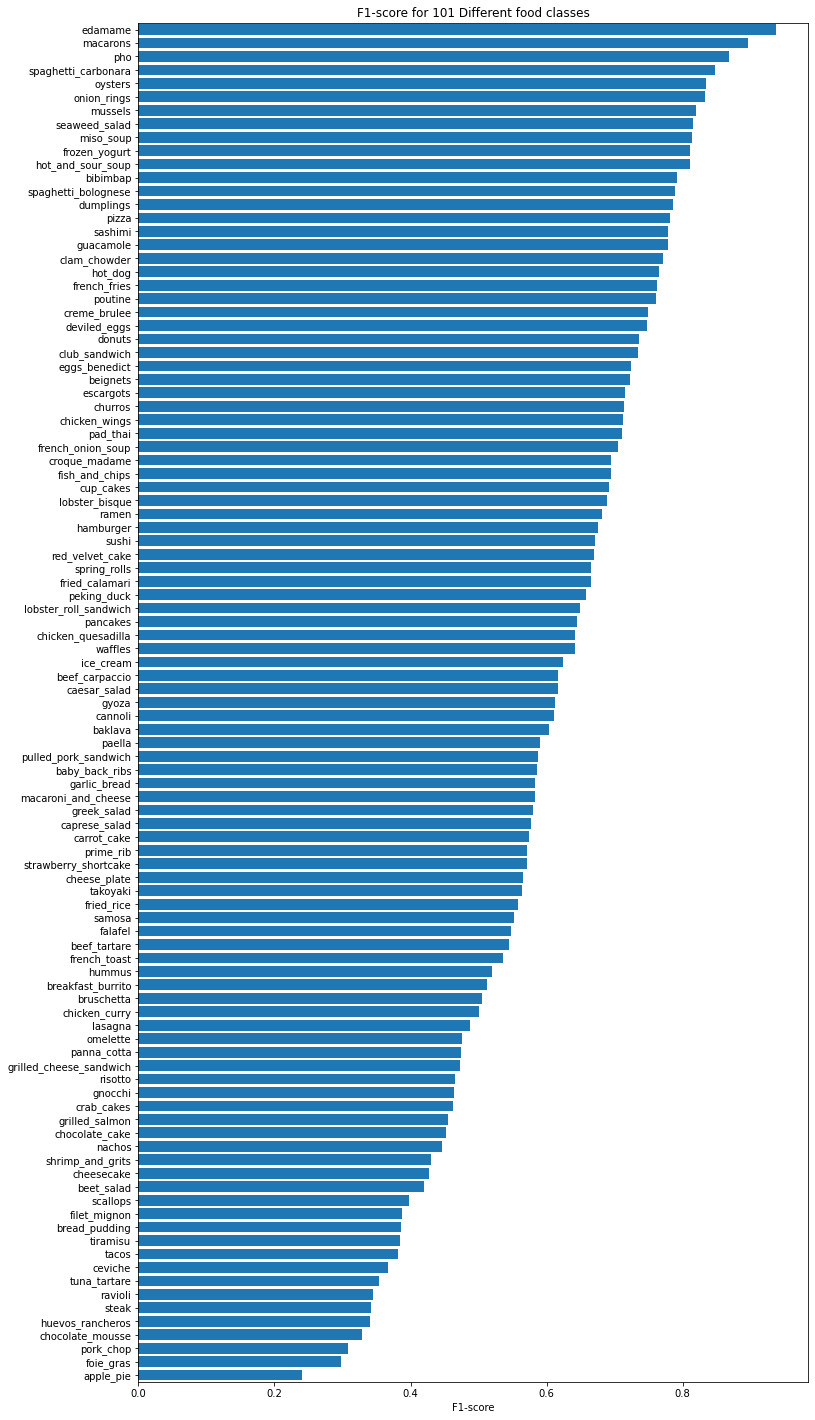

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_score)), f1_score["f1-score"].values)
ax.set_yticks(range(len(f1_score)))
ax.set_yticklabels(f1_score["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 Different food classes")
ax.set_ylim(bottom=-0.5, top=100.5)
ax.invert_yaxis()
plt.show()

## Visualizing predictions on custom images

How does our model go on food images not even in our test dataset.

To visualize, we'll need a function which will:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (ing_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-225 to 0-1 or not.

  Returns:
    Images tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # Don't need to rescale with EfficientNet

Next step :
1. Load a few random images from the test dataset
2. Make predictions on loaded images
3. PLot the original images along with the model's prediction probability and truth label

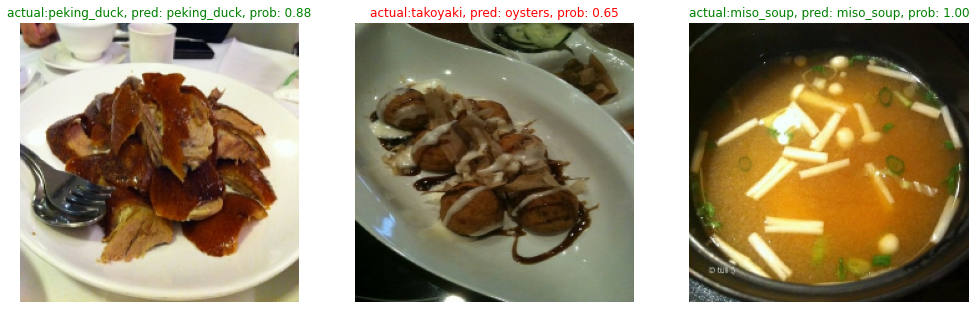

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random images from a random classes
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  
  # Load the images and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded) # get the prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index
  #print(pred_prob)
  #print(pred_class)

  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "green"
  else:
    title_color = "red"
  plt.title(f"actual:{class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find where our model is the most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names and ground truth class names
3. Use our DataFrame to find all the wrong predictions (where the ground truth label does not match the predictions).
4. Sort the DataFrane based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. Get all of the image paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

In [ ]:
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classname      y_pred_classname  
0   0.848315        apple_pie                 gyoza  
1   0.963882        apple_pie             apple_pie  
2   0.959357        apple_pie             apple_pie  
3   0.658263        apple_pie  pulled_pork_sandwich  
4   0.366545        apple_pie             prime_rib

In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

In [ ]:
pred_df.head(2)

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.848315        apple_pie            gyoza         False  
1   0.963882        apple_pie        apple_pie          True

In [ ]:
# 4. Sort our DataFrame to have the most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(10)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999946               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999905                  sushi                sashimi         False

In [ ]:
# 5. Visualize the tes data samples which have the wrong predictions but the highest pred probability
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  print(i)
  print(row)

0
Pandas(Index=21810, img_path=b'/content/101_food_classes_10_percent/test/scallops/1784196.jpg', y_true=87, y_pred=29, pred_conf=0.9999970197677612, y_true_classname='scallops', y_pred_classname='cup_cakes', pred_correct=False)
1
Pandas(Index=231, img_path=b'/content/101_food_classes_10_percent/test/apple_pie/827575.jpg', y_true=0, y_pred=100, pred_conf=0.9999947547912598, y_true_classname='apple_pie', y_pred_classname='waffles', pred_correct=False)
2
Pandas(Index=15359, img_path=b'/content/101_food_classes_10_percent/test/lobster_roll_sandwich/2325607.jpg', y_true=61, y_pred=53, pred_conf=0.9999877214431763, y_true_classname='lobster_roll_sandwich', y_pred_classname='hamburger', pred_correct=False)
3
Pandas(Index=23539, img_path=b'/content/101_food_classes_10_percent/test/strawberry_shortcake/16590.jpg', y_true=94, y_pred=83, pred_conf=0.999987006187439, y_true_classname='strawberry_shortcake', y_pred_classname='red_velvet_cake', pred_correct=False)
4
Pandas(Index=21400, img_path=b'/

<Figure size 1080x720 with 0 Axes>

In [ ]:
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few params of each row (tuple syntax)
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, \nprob: {pred_prob}")
  plt.axis(False);

## Test out the big dog model on our own custom images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2022-10-12 04:02:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 74.125.129.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.05s   

2022-10-12 04:02:28 (265 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg']

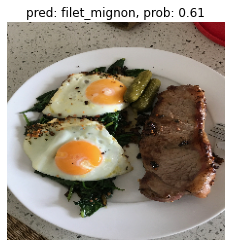

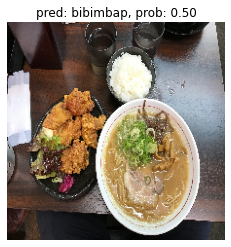

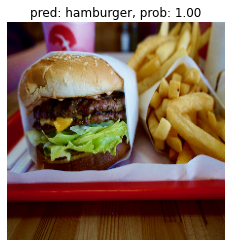

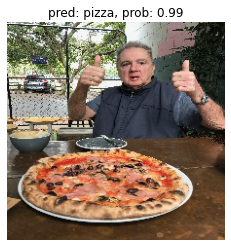

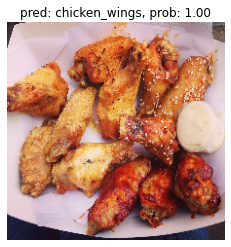

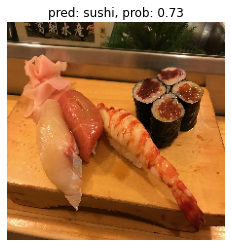

In [ ]:
# Make predictions on the images and plot them
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot the image
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False);